This is an illustrative example of a Pairs Trading involving Coca-Cola (KO) and PepsiCo (PEP), despite being fundamentaly different companies, for example, KO has half the sales of PEP but has a higher Net Income however they both manufacture, distribute and sell soft beverages.

But the market already knows past information if any new information is released, specially if affects both companies like for example new regulations affecting the beverage market, its expected that it will affect both companies in the same way therefore the price of each should move in the same direction.

This strategy falls on the expectation that when prices depart from their historic equilibrium (rolling correlation), the one that valued less in the last week will catchup during the trade session, being the positions open at open price and closed at close price (slippage can be factored in but its not accounted on this version of the script), if the position doesn't return profit its hold for another day and then liquidated at close T+1 no matter its net return.

#### If you enjoy this type of content, consider checking my website: https://www.leonardofilipe.com

In [1]:
# author: Leonardo Filipe
# email: contact@leonardofilipe.com
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn')

def getdata(tickers,start,end,frequency):
    OHLC = {}
    cookie = ''
    crumb = ''
    res = requests.get('https://finance.yahoo.com/quote/SPY/history')
    cookie = res.cookies['B']
    pattern = re.compile('.*"CrumbStore":\{"crumb":"(?P<crumb>[^"]+)"\}')
    for line in res.text.splitlines():
        m = pattern.match(line)
        if m is not None:
            crumb = m.groupdict()['crumb']
    for ticker in tickers:
        url_str = "https://query1.finance.yahoo.com/v7/finance/download/%s"
        url_str += "?period1=%s&period2=%s&interval=%s&events=history&crumb=%s"
        url = url_str % (ticker, start, end, frequency, crumb)
        res = requests.get(url, cookies={'B': cookie}).text
        OHLC[ticker] = pd.read_csv(io.StringIO(res), index_col=0,
                                   error_bad_lines=False).replace('null', np.nan).dropna()
        OHLC[ticker].index = pd.to_datetime(OHLC[ticker].index)
        OHLC[ticker] = OHLC[ticker].apply(pd.to_numeric)
    return OHLC

tickers = ['PEP','KO']

data = None
while data is None:
    try:
        data = getdata(tickers,'946610000','1538960000','1d')
    except:
         pass

PEP = data['PEP']
KO = data['KO']

In [2]:
PEP.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,
2018-10-03,2018-10-03,109.209999,109.709999,107.169998,107.519997,107.519997,6107500
2018-10-04,2018-10-04,106.849998,107.400002,105.800003,106.610001,106.610001,4930300
2018-10-05,2018-10-05,106.250000,107.010002,105.980003,106.489998,106.489998,3438100
2018-10-08,2018-10-08,106.360001,108.339996,106.309998,108.190002,108.190002,3994100
2018-10-09,2018-10-09,108.680000,108.940002,107.519997,108.120003,108.120003,4105600


In [3]:
ReturnPEP = PEP['Close']/PEP['Close'].shift(1)-1
BuyHoldPEP = PEP['Adj Close']/float(PEP['Adj Close'][:1])-1

ReturnKO = KO['Close']/KO['Close'].shift(1)-1
BuyHoldKO = KO['Adj Close']/float(KO['Adj Close'][:1])-1

ReturnBoth = (ReturnPEP+ReturnKO)/2
BuyHoldBoth = (BuyHoldPEP*0.5+BuyHoldKO*0.5).fillna(method='ffill')

In [4]:
pairs = pd.DataFrame({'TPEP':(PEP['Close']/PEP['Close'].shift(5)-1).shift(1),
                      'TKO':(KO['Close']/KO['Close'].shift(5)-1).shift(1)})

pairs['Target'] = pairs.min(axis=1)

pairs['PEP'] = PEP['Close']/PEP['Open']-1
pairs['PEP'][pairs['PEP'] < 0]  = PEP['Close'].shift(-1)/PEP['Open']-1

pairs['KO'] = KO['Close']/KO['Open']-1
pairs['KO'][pairs['KO'] < 0] = KO['Close'].shift(-1)/KO['Open']-1

pairs['Correlation'] = ((PEP['Close']/PEP['Close'].shift(7)-1).rolling(window=13)
                        .corr((KO['Close']/KO['Close'].shift(7)-1))).shift(1)
pairs = pairs.dropna()

signalPEP = pairs['PEP'].loc[pairs['Target'].isin(pairs['TPEP'])][pairs['Correlation'] < 0.9]
signalKO = pairs['KO'].loc[pairs['Target'].isin(pairs['TKO'])][pairs['Correlation'] < 0.9]

returns = signalPEP.add(signalKO,fill_value=0)
cumulret = returns.cumsum()

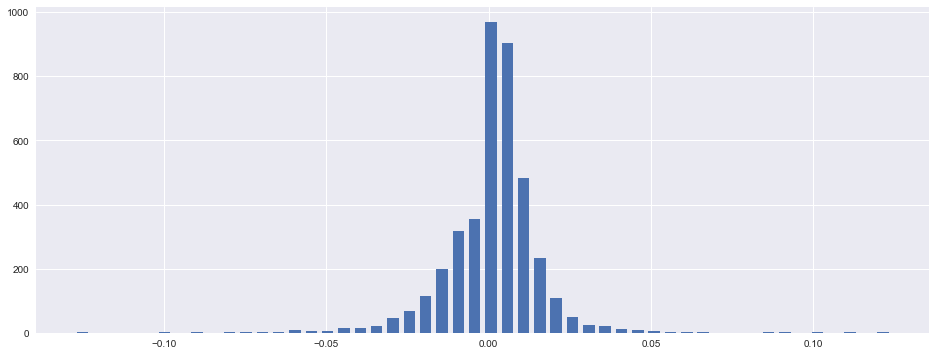

Mean return = 0.13 %
Standard deviaton = 1.44 %
Worst return = -12.76 %
Best return = 12.39 %
Lower quantile = -0.44 %
Median return = 0.26 %
Upper quantile = 0.78 %


In [5]:
fig, ax = plt.subplots(figsize=(16,6))
hist, bins = np.histogram(returns, bins=50)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
ax.bar(center, hist, align='center', width=width)
plt.show()
print('Mean return =',round((returns.mean())*100,2),"%")
print('Standard deviaton =',round((returns.std())*100,2),"%")
print("=========================")
print('Worst return =',round((min(returns))*100,2),"%")
print('Best return =',round((max(returns))*100,2),"%")
print("=========================")
print('Lower quantile =',round((returns.quantile(q=0.25))*100,2),"%")
print('Median return =',round((returns.quantile(q=0.5))*100,2),"%")
print('Upper quantile =',round((returns.quantile(q=0.75))*100,2),"%")

In [6]:
maxdd = round(max(np.maximum.accumulate(cumulret)-cumulret)*100,2)

mask = returns<0
diffs = np.diff(mask.astype(int))
start_mask = np.append(True,diffs==1) 
mask1 = mask & ~(start_mask & np.append(diffs==-1,True))
id = (start_mask & mask1).cumsum()
out = np.bincount(id[mask1]-1,returns[mask1])
badd = round(max(-out)*100,2)

executionrate = round((len(returns)/len(ReturnBoth))*100,2)

spositive = returns[returns > 0]
snegative = -returns[returns < 0]
winrate = round((len(spositive)/(len(spositive)+len(snegative)))*100,2)

beta = round(returns.corr(ReturnBoth),2)

sharpe = round((float(cumulret[-1:]))/cumulret.std(),2)

tret = round((float(cumulret[-1:]))*100,2)

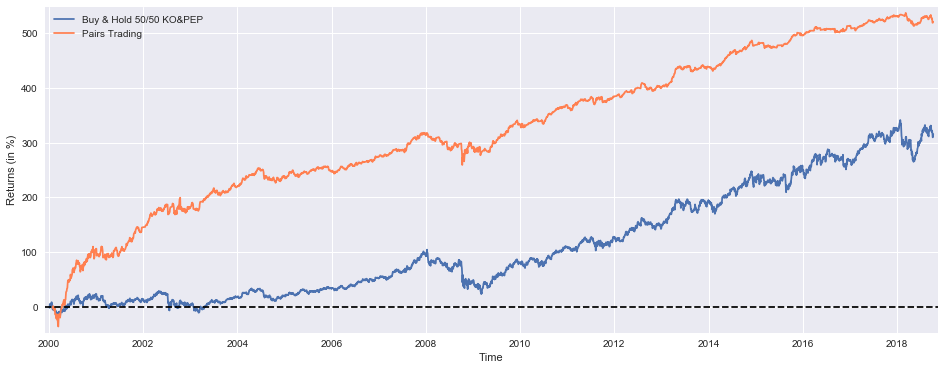

Cumulative Return =  520.59 %
Execution Rate =  85.05 %
Win Rate =  66.87 %
Maximum Loss =  58.79 %
Maximum Consecutive Loss =  39.33 %
Beta =  0.55
Sharpe =  3.87


In [7]:
plt.figure(figsize=(16,6))
plt.plot(BuyHoldBoth*100, label='Buy & Hold 50/50 KO&PEP')
plt.plot(cumulret*100, label='Pairs Trading', color='coral')
plt.xlabel('Time')
plt.ylabel('Returns (in %)')
plt.margins(x=0.005,y=0.02)
plt.axhline(y=0, xmin=0, xmax=1, linestyle='--', color='k')
plt.legend()
plt.show()
print("Cumulative Return = ",tret,"%")
print("=========================")
print("Execution Rate = ",executionrate,"%")
print("Win Rate = ",winrate,"%")
print("=========================")
print("Maximum Loss = ",maxdd,"%")
print("Maximum Consecutive Loss = ",badd,"%")
print("=========================")
print("Beta = ",beta)
print("Sharpe = ",sharpe)